In [ ]:
NOISE_VAR   = 2.511*(10^(-13))
NUM_PILOTS_T= 4
AP_ANTENNAS = 1
AREA_KM     = 0.250
NUM_APs     = 100
NUM_USERS   = 20
p_Transmit  = .450
delta       = 0.7
Rho_u       = p_Transmit/NOISE_VAR ;
Power_Control=0;

In [ ]:
import numpy as np
import random
def function_ApSelection(NUM_APs, NUM_USERS, AREA_KM, delta,seed):
    h_BS = 15  # Base station height in m
    h_mobile = 1.65  # Mobile height in m
    frequency = 1900  # Frequency in MHz
    aL = (1.1 * np.log10(frequency) - 0.7) * h_mobile - (1.56 * np.log10(frequency) - 0.8)
    L = 46.3 + 33.9 * np.log10(frequency) - 13.82 * np.log10(h_BS) - aL
    d0 = 0.01  # km
    d1 = 0.05  # km
    random.seed(seed)
    # Uniform locations of M APs:
    AP = np.zeros((NUM_APs, 2))
    corner = int(np.sqrt(NUM_APs))
    points = (AREA_KM / corner) * np.concatenate([
        np.sort(-np.random.permutation(np.arange(1, corner // 2 + 1))),
        np.array([0]),
        np.sort(np.random.permutation(np.arange(1, corner // 2 + 1)))
    ]) - AREA_KM * (AREA_KM / 2)

    ap_coordinates = []  # List to store AP coordinates
    m = 0
    for i in range(corner):
        for j in range(corner):
            if m < NUM_APs:  # Check to avoid index error if NUM_APs is not a perfect square
                AP[m, :] = [points[i], points[j]]
                ap_coordinates.append([points[i], points[j]])  # Store AP coordinates
                m += 1

    # Wrapped around (8 neighbor cells)
    D1 = np.zeros((NUM_APs, 2))
    D1[:, 0] += AREA_KM
    AP1 = AP + D1

    D2 = np.zeros((NUM_APs, 2))
    D2[:, 1] += AREA_KM
    AP2 = AP + D2

    D3 = np.zeros((NUM_APs, 2))
    D3[:, 0] -= AREA_KM
    AP3 = AP + D3

    D4 = np.zeros((NUM_APs, 2))
    D4[:, 1] -= AREA_KM
    AP4 = AP + D4

    D5 = D1.copy()
    D5[:, 1] -= AREA_KM
    AP5 = AP + D5

    D6 = D3.copy()
    D6[:, 1] += AREA_KM
    AP6 = AP + D6

    D7 = np.ones((NUM_APs, 2)) * AREA_KM
    AP7 = AP + D7

    D8 = -np.ones((NUM_APs, 2)) * AREA_KM
    AP8 = AP + D8

    # Randomly locations of K terminals:
    Ter = np.random.uniform(-AREA_KM / 2, AREA_KM / 2, (NUM_USERS, 2))
    user_coordinates = Ter.tolist()  # Convert user coordinates to a list

    # The rest of the code...
    UEpositions = (Ter[:, 0] + AREA_KM / 2) + 1j * (Ter[:, 1] + AREA_KM / 2) * 1000
    sigma_shd = 8  # in dB
    dist_user = np.zeros((NUM_USERS, NUM_USERS))
    for t in range(NUM_USERS):
        for ut in range(t, NUM_USERS):
            dist_user[t, ut] = np.linalg.norm(Ter[t, :] - Ter[ut, :])
    # Create an MxK large-scale coefficients beta_mk
    BETAA = np.zeros((NUM_APs, NUM_USERS))
    dist = np.zeros((NUM_APs, NUM_USERS))
    for m in range(NUM_APs):
        for k in range(NUM_USERS):
            distances = np.array([
                np.linalg.norm(AP[m, :] - Ter[k, :]),
                np.linalg.norm(AP1[m, :] - Ter[k, :]),
                np.linalg.norm(AP2[m, :] - Ter[k, :]),
                np.linalg.norm(AP3[m, :] - Ter[k, :]),
                np.linalg.norm(AP4[m, :] - Ter[k, :]),
                np.linalg.norm(AP5[m, :] - Ter[k, :]),
                np.linalg.norm(AP6[m, :] - Ter[k, :]),
                np.linalg.norm(AP7[m, :] - Ter[k, :]),
                np.linalg.norm(AP8[m, :] - Ter[k, :])
            ])
            dist[m, k], _ = np.min(distances), np.argmin(distances)
            if dist[m, k] < d0:
                betadB = -L - 35 * np.log10(d1) + 20 * np.log10(d1) - 20 * np.log10(d0)
            elif d0 <= dist[m, k] <= d1:
                betadB = -L - 35 * np.log10(d1) + 20 * np.log10(d1) - 20 * np.log10(dist[m, k])
            else:
                betadB = -L - 35 * np.log10(dist[m, k]) + sigma_shd * np.random.randn()
            BETAA[m, k] = 10 ** (betadB / 10)

    beta = BETAA

    # Access point Selection matrix
    A = np.zeros((NUM_APs, NUM_USERS))
    for k in range(NUM_USERS):
        beta_sort = np.sort(beta[:, k])[::-1]
        beta_index = np.argsort(beta[:, k])[::-1]
        denom_ApSel = np.sum(beta[:, k])
        temp_ApSel = 0
        c = 0
        for m in range(NUM_APs):
            temp_ApSel += beta_sort[m]
            c += 1
            if temp_ApSel >= delta * denom_ApSel:
                break
            A[beta_index[c - 1], k] = 1
        A[beta_index[c - 1], k] = 1

    return A, beta, ap_coordinates, user_coordinates

# Example usage
NUM_APs = 100  # For example
NUM_USERS = 20  # For example
AREA_KM = 0.250  # For example
delta = 0.7  # For example
seed = 42
A, beta, ap_coordinates, user_coordinates = function_ApSelection(NUM_APs, NUM_USERS, AREA_KM, delta,seed)

print("AP Coordinates:", ap_coordinates)
print("User Coordinates:", user_coordinates)


AP Coordinates: [[-0.15625, -0.15625], [-0.15625, -0.13125], [-0.15625, -0.10625000000000001], [-0.15625, -0.08125], [-0.15625, -0.05625], [-0.15625, -0.03125], [-0.15625, -0.006249999999999999], [-0.15625, 0.018750000000000003], [-0.15625, 0.04375000000000001], [-0.15625, 0.06875], [-0.13125, -0.15625], [-0.13125, -0.13125], [-0.13125, -0.10625000000000001], [-0.13125, -0.08125], [-0.13125, -0.05625], [-0.13125, -0.03125], [-0.13125, -0.006249999999999999], [-0.13125, 0.018750000000000003], [-0.13125, 0.04375000000000001], [-0.13125, 0.06875], [-0.10625000000000001, -0.15625], [-0.10625000000000001, -0.13125], [-0.10625000000000001, -0.10625000000000001], [-0.10625000000000001, -0.08125], [-0.10625000000000001, -0.05625], [-0.10625000000000001, -0.03125], [-0.10625000000000001, -0.006249999999999999], [-0.10625000000000001, 0.018750000000000003], [-0.10625000000000001, 0.04375000000000001], [-0.10625000000000001, 0.06875], [-0.08125, -0.15625], [-0.08125, -0.13125], [-0.08125, -0.1062

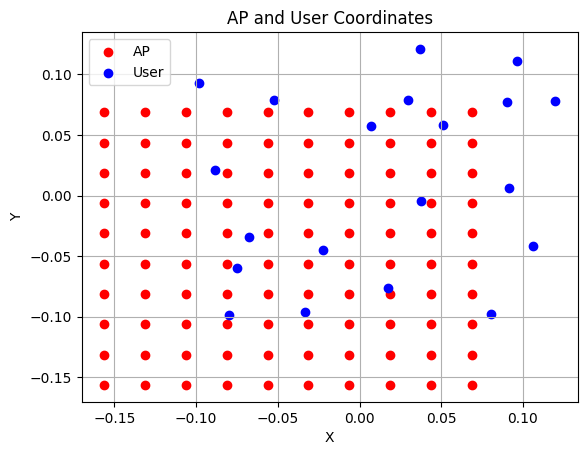

In [ ]:
import matplotlib.pyplot as plt
ap_coordinates = np.array(ap_coordinates)
plt.scatter(ap_coordinates[:, 0], ap_coordinates[:, 1], c='r', label='AP')

# Plotting User Coordinates
user_coordinates = np.array(user_coordinates)
plt.scatter(user_coordinates[:, 0], user_coordinates[:, 1], c='b', label='User')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('AP and User Coordinates')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import networkx as nx

In [ ]:
g=nx.Graph()

In [ ]:
user_nodes= range(1, NUM_USERS+1)

In [ ]:
g.add_nodes_from(user_nodes, node_type='user')

In [ ]:
for user in user_nodes:
  g.nodes[user]['pos'] = (user_coordinates[user-1][0],user_coordinates[user-1][1])

In [ ]:
p= nx.get_node_attributes(g, 'pos')

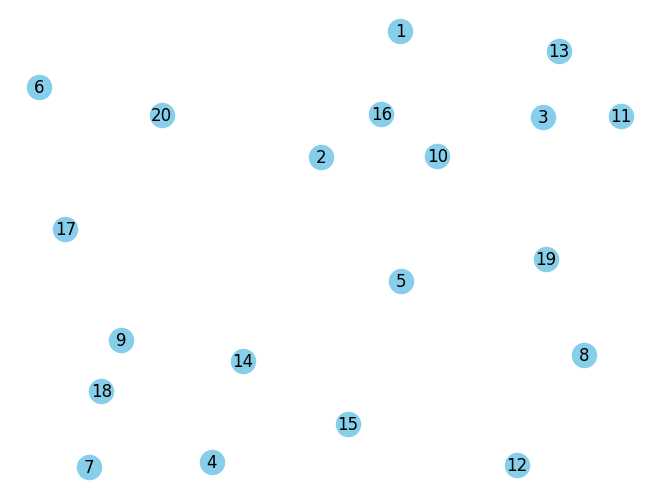

In [ ]:
nx.draw(g, p , with_labels=True, node_size=300, node_color='skyblue', font_color='black')

In [ ]:
d_thresh= 0.06

In [ ]:
for i in range(NUM_USERS):
    for j in range(i+1, NUM_USERS):
        x1=g.nodes[i+1]['pos'][0]
        y1=g.nodes[i+1]['pos'][1]
        x2=g.nodes[j+1]['pos'][0]
        y2=g.nodes[j+1]['pos'][1]

        d= np.linalg.norm(np.array([x1, y1])-np.array([x2,y2]))
        if d<d_thresh:
            g.add_edge(i+1, j+1, dummy_edge='False')

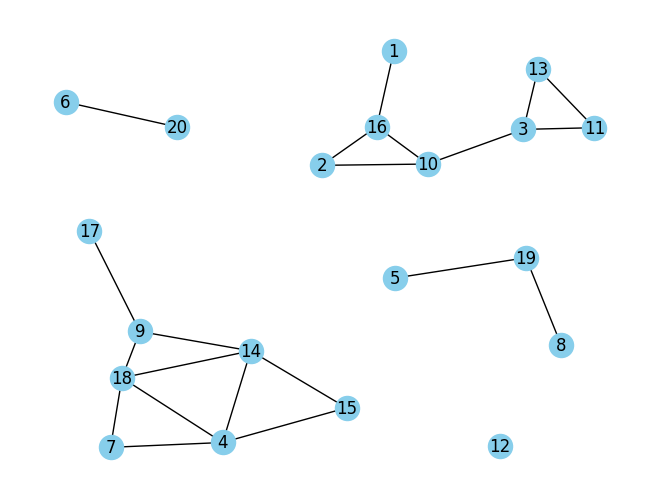

In [ ]:
nx.draw(g, p , with_labels=True, node_size=300, node_color='skyblue', font_color='black')

In [ ]:
g.remove_edges_from(g.edges())

In [ ]:
num_anchors=100

In [ ]:
anchors= range(NUM_USERS+1, NUM_USERS+num_anchors+1)

In [ ]:
g.add_nodes_from(anchors, node_type='anchor')

In [ ]:
for anchor in anchors:
    g.nodes[anchor]['pos']= (ap_coordinates[anchor-NUM_USERS-1][0]+0.05,ap_coordinates[anchor-NUM_USERS-1][1]+0.05)

In [ ]:
p= nx.get_node_attributes(g, 'pos')

In [ ]:
node_color= ['skyblue' if g.nodes[node]['node_type']=='user' else 'yellow' for node in g.nodes]

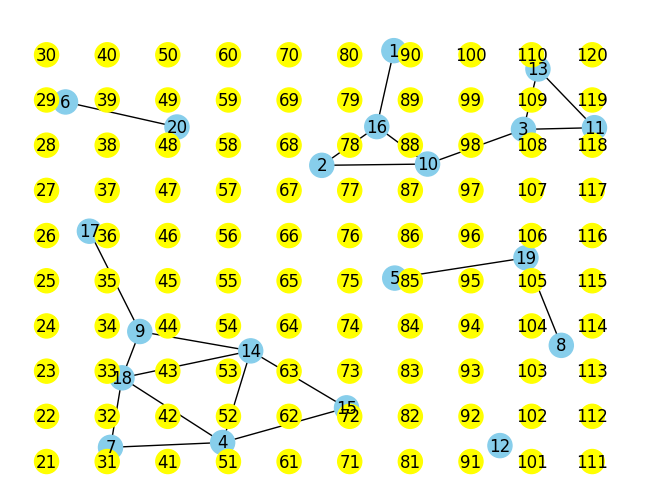

In [ ]:
nx.draw(g, p, node_color= node_color, node_size=300, with_labels=True, font_color='black')

In [ ]:
g.remove_nodes_from(list(anchors))

In [ ]:
anchor_thresh=10

In [ ]:
from scipy.spatial.distance import euclidean

In [ ]:
for user in user_nodes:
    user_pos = g.nodes[user]['pos']
    dists = [(anchor, euclidean(user_pos, g.nodes[anchor]['pos'])) for anchor in anchors]
    dists.sort(key=lambda x: x[1])
    g.nodes[user]['nearest'] = [anchor[0] for anchor in dists[:20]]

    for i in range(min(anchor_thresh, len(dists))):
        g.add_edge(user, dists[i][0], dummy_edge='False')

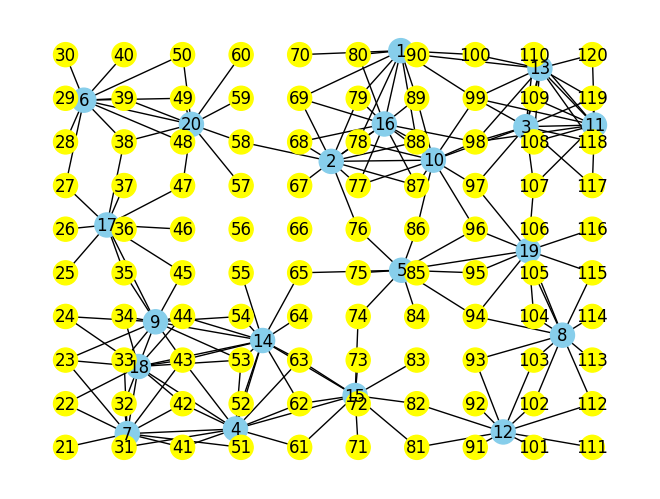

In [ ]:
nx.draw(g, p, node_color= node_color, node_size=300, with_labels=True, font_color='black')

In [ ]:
near_thresh=4

In [ ]:
for u1 in user_nodes:
    for u2 in user_nodes:
        if u1<u2:
            anchor_u1= set(g.nodes[u1]['nearest'][:20])
            anchor_u2= set(g.nodes[u2]['nearest'][:20])

            common= anchor_u1.intersection(anchor_u2)
            if len(common)>=near_thresh:
                if not g.has_edge(u1, u2):
                    g.add_edge(u1, u2, dummy_edge=True)

In [ ]:
dummy= [(u, v) for u,v, data in g.edges(data=True) if data['dummy_edge']==True]

In [ ]:
len(g.edges)

270

In [ ]:
len(dummy)

49

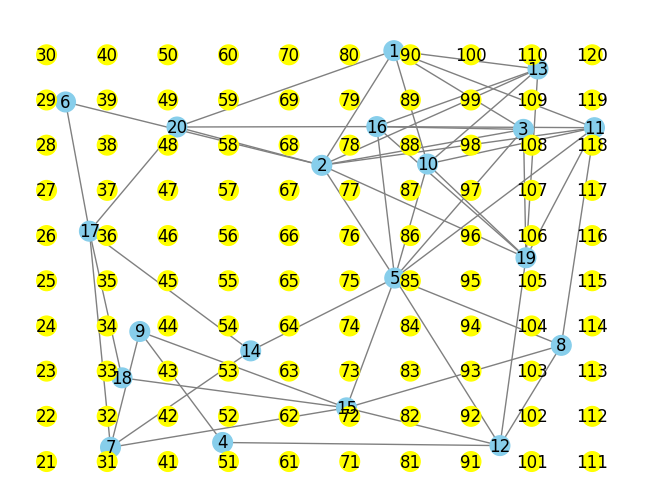

In [ ]:
nx.draw(g, p, node_color=node_color, node_size=200, with_labels=True, edgelist=dummy, edge_color='gray')

In [ ]:
edge_color=['red' if data['dummy_edge']==True else 'black' for u, v, data in g.edges(data=True)]

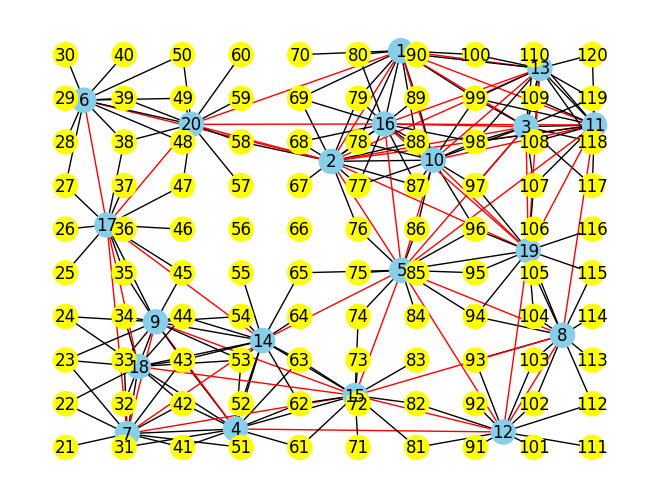

In [ ]:
nx.draw(g, p, node_color=node_color, node_size=300, with_labels=True, edge_color=edge_color)

In [ ]:
A

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
common_thresh = 2
for i in range(0,NUM_USERS-1):
  for j in range(i+1,NUM_USERS):
      count = 0
      for k in range(0,NUM_APs):
        if(A[k][i]==1 and A[k][j]==1):
          count=count+1
      if(count>=common_thresh):
        g.add_edge(i+1,j+1,dummy_edge = True)

In [ ]:
dummy= [(u, v) for u,v, data in g.edges(data=True) if data['dummy_edge']==True]
len(dummy)

79

In [ ]:
V= NUM_USERS

In [ ]:
limit=4

In [ ]:
def is_safe(v, graph, color, c,count):
    for i in range(V):
        if ((graph[v][i] and c==color[i]) or count[c]==limit):
            return False
    return True

In [ ]:
def graph_color(graph, m, color, v,count):
    if v==V:
        return True

    for c in range(1, m+1):
        if is_safe(v, graph, color, c,count):
            color[v]=c
            count[c]=count[c] + 1
            if graph_color(graph, m, color, v+1,count):
                return True

        color[v]=0

    return False

In [ ]:
def print_solution(color):
    print("Solution Exists: Following are the assigned colors")
    for i in range(V):
        print(color[i], end=" ")
    print("\n")

In [ ]:
def coloring(graph, m):
    color= [0]*V
    count = [0]*(m+1)
    if not graph_color(graph, m, color, 0,count):
        print("Solution does not exist")
        return False

    print_solution(color)
    print("Length of color array:", len(color))  # Add this line
    return color

In [ ]:
nx.get_node_attributes(g, 'node_type').items()

dict_items([(1, 'user'), (2, 'user'), (3, 'user'), (4, 'user'), (5, 'user'), (6, 'user'), (7, 'user'), (8, 'user'), (9, 'user'), (10, 'user'), (11, 'user'), (12, 'user'), (13, 'user'), (14, 'user'), (15, 'user'), (16, 'user'), (17, 'user'), (18, 'user'), (19, 'user'), (20, 'user'), (21, 'anchor'), (22, 'anchor'), (23, 'anchor'), (24, 'anchor'), (25, 'anchor'), (26, 'anchor'), (27, 'anchor'), (28, 'anchor'), (29, 'anchor'), (30, 'anchor'), (31, 'anchor'), (32, 'anchor'), (33, 'anchor'), (34, 'anchor'), (35, 'anchor'), (36, 'anchor'), (37, 'anchor'), (38, 'anchor'), (39, 'anchor'), (40, 'anchor'), (41, 'anchor'), (42, 'anchor'), (43, 'anchor'), (44, 'anchor'), (45, 'anchor'), (46, 'anchor'), (47, 'anchor'), (48, 'anchor'), (49, 'anchor'), (50, 'anchor'), (51, 'anchor'), (52, 'anchor'), (53, 'anchor'), (54, 'anchor'), (55, 'anchor'), (56, 'anchor'), (57, 'anchor'), (58, 'anchor'), (59, 'anchor'), (60, 'anchor'), (61, 'anchor'), (62, 'anchor'), (63, 'anchor'), (64, 'anchor'), (65, 'anchor'

In [ ]:
user1= [node for node, node_type in nx.get_node_attributes(g, 'node_type').items() if node_type=='user']

In [ ]:
user_g= nx.subgraph(g, user1)

In [ ]:
p1= nx.get_node_attributes(user_g, 'pos')

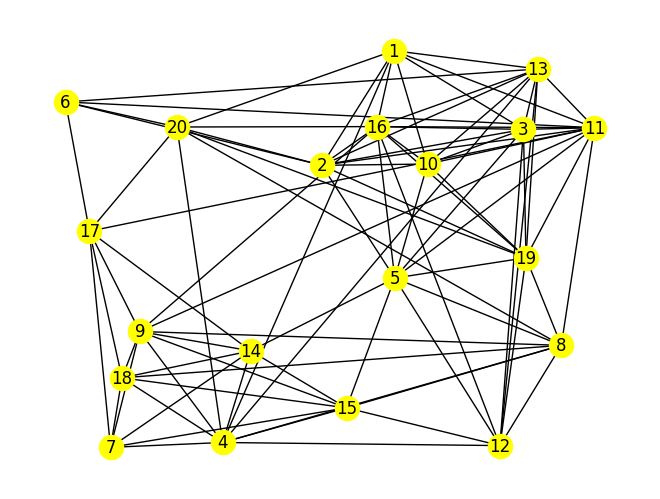

In [ ]:
nx.draw(user_g, p1, node_color= 'yellow', node_size=300, with_labels=True, font_color='black')

In [ ]:
# Convert NetworkX graph to adjacency matrix
adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(user_g).toarray().astype(int)

In [ ]:
adjacency_matrix

array([[0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0],
       [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 1, 1,

In [ ]:
colors= coloring(adjacency_matrix, 8)

Solution Exists: Following are the assigned colors
1 2 3 2 1 1 1 3 4 4 5 4 6 3 5 7 2 6 8 4 

Length of color array: 20


In [ ]:
user_colors= {user: colors[i] for i, user in enumerate(user_nodes)}

In [ ]:
nx.set_node_attributes(user_g, user_colors, 'color')

In [ ]:
node_c= nx.get_node_attributes(user_g, 'color').values()

In [ ]:
non_dummy_users= [(u, v) for u, v, data in user_g.edges(data=True) if not data['dummy_edge']==True]

In [ ]:
len(non_dummy_users)

7

In [ ]:
len(user_g.edges)

86

In [ ]:
type(non_dummy_users)

list

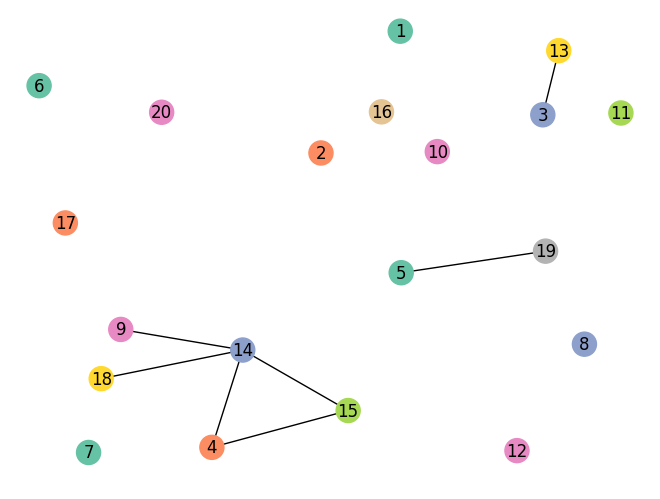

In [ ]:
nx.draw(user_g, p1, node_color=list(node_c), node_size=300, with_labels=True, font_color='black', cmap='Set2', edgelist=non_dummy_users)